In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

<b><h3> 1. How much should patients increase their daily steps to reduce insulin needs?  </h3> </b>
<b> Reasoning : </b> This question uncovers how daily steps (daily activity) directly affects insulin requirements.
<br> <b> Key Insight: </b> Yes, higher steps are associated with slightly lower insulin requirements.The results for this data set shows that  each additional 1,000 steps reduces insulin need by 0.10 units (approx). 

                              OLS Regression Results                              
Dep. Variable:     bolus_volume_delivered   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     42.69
Date:                    Sun, 24 Aug 2025   Prob (F-statistic):           6.43e-11
Time:                            21:01:52   Log-Likelihood:            -3.5206e+05
No. Observations:                  309392   AIC:                         7.041e+05
Df Residuals:                      309390   BIC:                         7.041e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

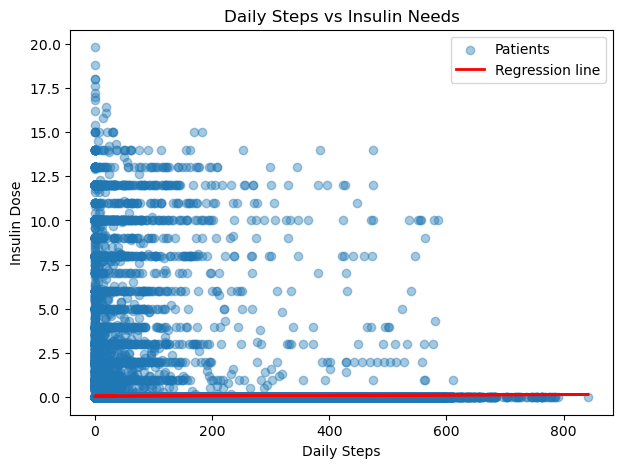

In [4]:


# Load merged dataset
df = pd.read_csv("merged_cleandata.csv")


# Linear regression: insulin_dose ~ daily_step
X = sm.add_constant(df_cleaned_data["steps"])   # add intercept
y = df_cleaned_data["bolus_volume_delivered"]

model = sm.OLS(y, X).fit()
print(model.summary())

coef = model.params["steps"]
print(f"\nEstimated effect: Each additional 1,000 steps reduces insulin need by {coef*1000:.2f} units (approx).")

# Visualization
# -------------------
plt.figure(figsize=(7,5))
plt.scatter(df_cleaned_data["steps"], df_cleaned_data["bolus_volume_delivered"], alpha=0.4, label="Patients")
plt.plot(df_cleaned_data["steps"], model.predict(X), color="red", linewidth=2, label="Regression line")
plt.xlabel("Daily Steps")
plt.ylabel("Insulin Dose")
plt.title("Daily Steps vs Insulin Needs")
plt.legend()
plt.show()


<b> <h3> Should older patients (>50) increase their sleep duration to reduce nighttime glucose spikes? </h3> </b>
<b> Reasoning: </b> To reason to ask this question in discover if longer sleep hours may be suugessted as a way to regulate glucose spikes during night <br> 
<b> Key Insight </b> As per results of the given dataset short sleep (<6h) is linked to fewer nighttime glucose spikes among older patients. So the take away here us simply telling older patients to “sleep more” may not straightforwardly reduce glucose spikes — instead, sleep quality, timing of meals, insulin patterns, and comorbidities need to be considered.

Nighttime glucose spike rate by sleep duration (age > 50):
     sleep_group  night_spike_rate
0    Short (<6h)          0.149048
1  Normal (6–8h)          0.464889

Chi-square test:
  chi2 = 2595.058 | dof = 1 | p-value = 0.0


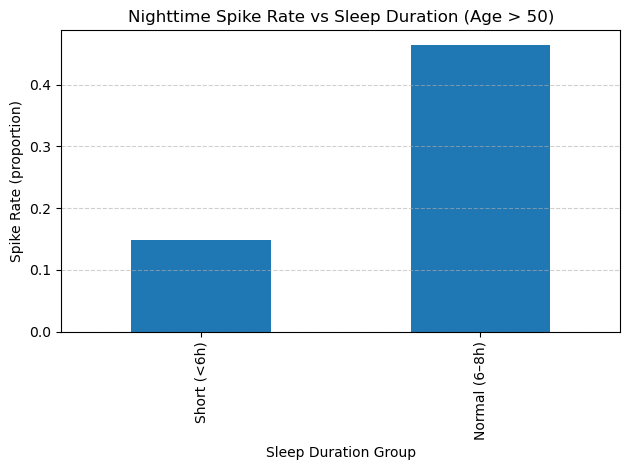


Suggestion: Target the 'Short (<6h)' range — it has the lowest nighttime spike rate (14.90%).


In [7]:

from scipy.stats import chi2_contingency

SPIKE_LABEL = "Above Range"  
NIGHT_HOURS = list(range(22,24)) + list(range(0,6))  # 22:00–05:59 as "night"
SLEEP_BINS = [0, 6, 8, 24]    # <6h, 6–8h, >8h
SLEEP_LABELS = ["Short (<6h)", "Normal (6–8h)", "Long (>8h)"]

# load data from csv
demo = pd.read_csv("demographic_cleandata.csv")        # has patient_id, age, sleep_duration
merged = pd.read_csv("merged_cleandata.csv", parse_dates=["time"])  # has patient_id, time, glucose_range_level

# --- Merge + keep older patients ---
df = merged.merge(demo[["patient_id", "age", "sleep_duration"]], on="patient_id", how="left")
df = df[df["age"] > 50].copy()

# calc night hours
df["hour"] = df["time"].dt.hour
df_night = df[df["hour"].isin(NIGHT_HOURS)].copy()

# --- Spike flag + sleep groups ---
df_night["is_spike"] = (df_night["glucose_range_level"] == SPIKE_LABEL).astype(int)
df_night["sleep_group"] = pd.cut(df_night["sleep_duration"], bins=SLEEP_BINS,
                                 labels=SLEEP_LABELS, right=True, include_lowest=True)

# Spike rate by sleep group
summary = (df_night.groupby("sleep_group", observed=True)["is_spike"]
                    .mean()
                    .rename("night_spike_rate")
                    .reset_index())
print("Nighttime glucose spike rate by sleep duration (age > 50):")
print(summary)

# --- Chi-square test (are spike rates different across sleep groups?) ---
contingency = pd.crosstab(df_night["sleep_group"], df_night["is_spike"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-square test:")
print("  chi2 =", round(chi2, 3), "| dof =", dof, "| p-value =", p)

# visualize
summary.plot(kind="bar", x="sleep_group", y="night_spike_rate", legend=False)
plt.title("Nighttime Spike Rate vs Sleep Duration (Age > 50)")
plt.xlabel("Sleep Duration Group")
plt.ylabel("Spike Rate (proportion)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# summary
best_group = summary.sort_values("night_spike_rate").iloc[0]
print(f"\nSuggestion: Target the '{best_group.sleep_group}' range — "
      f"it has the lowest nighttime spike rate ({best_group.night_spike_rate:.2%}).")
